In [1]:
import json
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os

import tensorflow as tf
import tensorflow.contrib.eager as tfe
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

tf.enable_eager_execution()

dataset = '/home/martin/Programación/node-python/diabetes-ml/server/diabetes.csv'
dataset_50_50 = '/home/martin/Programación/node-python/diabetes-ml/server/50_50.csv'
dataset_80_20 = '/home/martin/Programación/node-python/diabetes-ml/server/80_20.csv'
dataset_60_40 = '/home/martin/Programación/node-python/diabetes-ml/server/80_20.csv'
dataset_20_80 = '/home/martin/Programación/node-python/diabetes-ml/server/20_80.csv'
dataset_20_81 = '/home/martin/Programación/node-python/diabetes-ml/server/20_81.csv'
dataset_20_80_norm = '/home/martin/Programación/node-python/diabetes-ml/server/20_80_norm.csv'
dataset_positivo = '/home/martin/Programación/node-python/diabetes-ml/server/diabetes_positivo.csv'
dataset_negativo = '/home/martin/Programación/node-python/diabetes-ml/server/diabetes_negativo.csv'
negativo = '/home/martin/Programación/node-python/diabetes-ml/server/negativo.csv'
dataset_train = dataset_20_80

In [2]:
from math import sin #para usar la función seno
 
from time import time #importamos la función time para capturar tiempos
  
tiempo_inicial = time() 


In [3]:
datos = pd.read_csv(dataset_20_80)

x = datos.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
#df.to_csv(dataset_20_80_norm,index=False)

datos.head()
#datos = pd.read_csv(dataset,iterator=True, chunksize=1000)
#datos = pd.concat([chunk[chunk['Resultado']==0] for chunk in datos])
#datos.to_csv(dataset_negativo,index=False)
#datos.head()

Embarazos  Glucosa  PresiónSanguínea  GrosorDeLaPiel  Insulina   IMC  \
0          6      148                72              35         0  33.6   
1          8      183                64               0         0  23.3   
2          0      137                40              35       168  43.1   
3          3       78                50              32        88  31.0   
4          2      197                70              45       543  30.5   

   FunciónDePedigríDiabetes  Edad  Resultado  
0                     0.627    50          1  
1                     0.672    32          1  
2                     2.288    33          1  
3                     0.248    26          1  
4                     0.158    53          1

In [4]:
datos.describe()

Embarazos     Glucosa  PresiónSanguínea  GrosorDeLaPiel    Insulina  \
count  320.000000  320.000000        320.000000      320.000000  320.000000   
mean     4.731250  135.721875         70.009375       21.353125   92.109375   
std      3.667568   34.073783         21.854246       17.392311  132.078455   
min      0.000000    0.000000          0.000000        0.000000    0.000000   
25%      1.000000  112.000000         64.750000        0.000000    0.000000   
50%      4.000000  134.000000         74.000000       26.000000    0.000000   
75%      7.000000  162.000000         82.000000       35.000000  156.000000   
max     17.000000  199.000000        114.000000       99.000000  846.000000   

              IMC  FunciónDePedigríDiabetes        Edad   Resultado  
count  320.000000                320.000000  320.000000  320.000000  
mean    34.040625                  0.533766   36.184375    0.837500  
std      8.099904                  0.366383   11.071175    0.369487  
min      0.000000                  0.088000   21.000000    0.000000  
25%     29.900000                  0.259750   27.000000    1.000000  
50%     33.750000                  0.427000   34.000000    1.000000  
75%     38.200000                  0.702500   43.000000    1.000000  
max     67.100000                  2.420000   70.000000    1.000000

In [5]:
datos.hist(figsize=(12,12));
datos['Resultado'].value_counts().plot(kind='bar')
no_diabeticos=52
diabeticos=268



In [6]:
X = datos[['Embarazos',
           'Glucosa',
           'PresiónSanguínea',
           'GrosorDeLaPiel',
           'Insulina',
           'IMC',
           'FunciónDePedigríDiabetes',
           'Edad']] 
Y = datos['Resultado']


In [7]:
def parse_csv(line):
    muestra_default = [[0.], [0.], [0.], [0.], [0.], [0.], [0.], [0.], [0]]  # sets field types
   
    parsed_line = tf.decode_csv(line, muestra_default) #Cada columna del dataset se asigna a un tensor.

    # Los primeros 8 campos son caracteristicas que se combinan en un solo tensor
    features = tf.reshape(parsed_line[:-1], shape=(8,))
    # Last field is the label
    label = tf.reshape(parsed_line[-1], shape=())
    return features, label

In [8]:
train_dataset = tf.data.TextLineDataset(dataset_train)
train_dataset = train_dataset.skip(1)             # skip the first header row
train_dataset = train_dataset.map(parse_csv)      # parse each row
#train_dataset = train_dataset.shuffle(buffer_size=200)  # randomize
train_dataset = train_dataset.shuffle(buffer_size=500)  # randomize
#train_dataset = train_dataset.batch(140)
train_dataset = train_dataset.batch(320)

# View a single example entry from a batch
iterator = train_dataset.make_one_shot_iterator()
features, label = iterator.get_next()

features, label = tfe.Iterator(train_dataset).next()
print("example features:", features[26])

example features: tf.Tensor([  3.    107.     62.     13.     48.     22.9     0.678  23.   ], shape=(8,), dtype=float32)


In [9]:
                                        

model = tf.keras.Sequential([
  tf.keras.layers.Dense(320,activation="tanh", input_shape=(8,)),
  tf.keras.layers.Dense(160,activation="tanh"),
  tf.keras.layers.Dense(80, activation="tanh"),
  tf.keras.layers.Dense(40, activation="tanh"),
  tf.keras.layers.Dense(20, activation="tanh"),
  tf.keras.layers.Dense(10,activation="tanh"), 
  tf.keras.layers.Dense(2,activation="tanh")
])


print('Creación de modelos ')

Creación de modelos 


In [10]:
def loss(model, x, y):
    y_ = model(x)
    return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

def grad(model, inputs, targets):
    with tfe.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, model.variables)

In [11]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

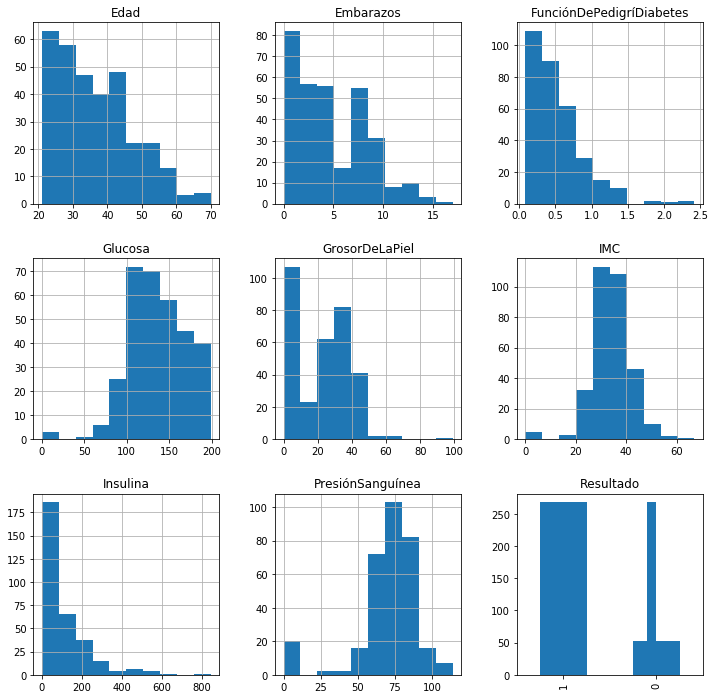

Época 000: Pérdida: 0.566, Eficiencia: 83.750%
Época 050: Pérdida: 0.407, Eficiencia: 83.750%
Época 100: Pérdida: 0.386, Eficiencia: 85.000%
Época 150: Pérdida: 0.371, Eficiencia: 85.312%
Época 200: Pérdida: 0.359, Eficiencia: 85.938%
Época 250: Pérdida: 0.347, Eficiencia: 86.562%
Época 300: Pérdida: 0.338, Eficiencia: 86.562%
Época 350: Pérdida: 0.330, Eficiencia: 86.875%
Época 400: Pérdida: 0.322, Eficiencia: 87.188%
Época 450: Pérdida: 0.323, Eficiencia: 86.562%


In [12]:
plt.show()
train_loss_results = []
train_accuracy_results = []

resultados_entrenamiento = {} 
resultados_entrenamiento['resultados'] = []
resultados_entrenamiento['prediccion'] = []
num_epochs = 500

for epoch in range(num_epochs):
    epoch_loss_avg = tfe.metrics.Mean()
    epoch_accuracy = tfe.metrics.Accuracy()

      # Training loop - using batches
    for x, y in tfe.Iterator(train_dataset):
        # Optimize the model
        grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.variables),
                                  global_step=tf.train.get_or_create_global_step())

        # Track progress
        epoch_loss_avg(loss(model, x, y))  # add current batch loss
        # compare predicted label to actual label
        epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

        # end epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    if epoch % 50 == 0:
        resultados_entrenamiento['resultados'].append({  
            'epoca': epoch,
            'perdida':'{:.3f}'.format(epoch_loss_avg.result()),
            'eficiencia':'{:.3%}'.format(epoch_accuracy.result()),
        })        
        
        print("Época {:03d}: Pérdida: {:.3f}, Eficiencia: {:.3%}".format(epoch,
                                                                    epoch_loss_avg.result(),
                                                                    epoch_accuracy.result()))
#with open('resultados_entrenamiento.json', 'w') as outfile:  
#    json.dump(resultados_entrenamiento, outfile)
    
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Métricas de entrenaniento')

axes[0].set_ylabel("Pérdida", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Eficiencia", fontsize=14)
axes[1].set_xlabel("Época", fontsize=14)
axes[1].plot(train_accuracy_results)




In [13]:
tiempo_final= time() 
 
tiempo_ejecucion = tiempo_final - tiempo_inicial
 
print ('El tiempo de ejecucion fue:',tiempo_ejecucion) #En segundos

El tiempo de ejecucion fue: 14.353293180465698


In [14]:

resultados = ["NEGATIVO", "POSITIVO"]
data = {} 
data['predicciones'] = []

with open('inputs_data.json') as json_data:
    d = json.load(json_data)


predict_dataset = tf.convert_to_tensor([
    [float(d['muestras'][0]['Embarazos']),
     float(d['muestras'][0]['Glucosa']),
     float(d['muestras'][0]['PresiónSanguínea']),
     float(d['muestras'][0]['GrosorDeLaPiel']),
     float(d['muestras'][0]['Insulina']),
     float(d['muestras'][0]['IMC']),
     float(d['muestras'][0]['FunciónDePedigríDiabetes']),
     float(d['muestras'][0]['Edad']),]
])

pred = {} 
predicciones = model(predict_dataset)
for i, logits in enumerate(predicciones):
    index = tf.argmax(logits).numpy()
    pred[i] = index
    resultado = resultados[index]
    print("Pedicción diabetes {} : {}".format(i, resultado))   
    resultados_entrenamiento['prediccion'].append({  
        'resultado': resultado,
    }) 
#resultado_entrenamiento['resultado'] = resultado 

with open('resultados_entrenamiento.json', 'w') as outfile:  
    json.dump(resultados_entrenamiento, outfile)

#with open('resultado.json', 'w') as outfile:  
#    json.dump(data, outfile)


Pedicción diabetes 0 : POSITIVO
